# Pump It Up: Data Mining the Water Table 

Competition hosted by DrivenData 

Goal: Predict the status (functional, non-functional, functional needs repair) of waterpoints in Tanzania

## First things first: importing the dataset and relevant libraries 

In [117]:
import math
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

import sci_analysis as analyze
import scipy.stats as st
from fancyimpute import KNN

from random import randint
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

%matplotlib inline

In [237]:
training_values = pd.read_csv('training_values.csv')
training_labels = pd.read_csv('training_labels.csv')
test_values = pd.read_csv('test_values.csv')

## On to exploring the data

What are we working with? Let's check out the features of this dataset and the labels for the waterpoints.

### Features

In [1339]:
print('The features of this dataset include:')
for column in training_values.columns:
    print(column)
print(training_values.shape)

The features of this dataset include:
id
amount_tsh
date_recorded
funder
gps_height
installer
longitude
latitude
wpt_name
num_private
basin
subvillage
region
region_code
district_code
lga
ward
population
public_meeting
recorded_by
scheme_management
scheme_name
permit
construction_year
extraction_type
extraction_type_group
extraction_type_class
management
management_group
payment
payment_type
water_quality
quality_group
quantity
quantity_group
source
source_type
source_class
waterpoint_type
waterpoint_type_group
(59400, 40)


In [1340]:
print('A sample of the values in those columns: \n')
print(training_values.head())

A sample of the values in those columns: 

      id  amount_tsh date_recorded        funder  gps_height     installer  \
0  69572      6000.0    2011-03-14         Roman        1390         Roman   
1   8776         0.0    2013-03-06       Grumeti        1399       GRUMETI   
2  34310        25.0    2013-02-25  Lottery Club         686  World vision   
3  67743         0.0    2013-01-28        Unicef         263        UNICEF   
4  19728         0.0    2011-07-13   Action In A           0       Artisan   

   longitude   latitude              wpt_name  num_private  \
0  34.938093  -9.856322                  none            0   
1  34.698766  -2.147466              Zahanati            0   
2  37.460664  -3.821329           Kwa Mahundi            0   
3  38.486161 -11.155298  Zahanati Ya Nanyumbu            0   
4  31.130847  -1.825359               Shuleni            0   

           ...          payment_type water_quality quality_group  \
0          ...              annually          s

In [1341]:
print('A quick description of the numerical features: \n')
print(training_values.describe())

A quick description of the numerical features: 

                 id     amount_tsh    gps_height     longitude      latitude  \
count  59400.000000   59400.000000  59400.000000  59400.000000  5.940000e+04   
mean   37115.131768     317.650385    668.297239     34.077427 -5.706033e+00   
std    21453.128371    2997.574558    693.116350      6.567432  2.946019e+00   
min        0.000000       0.000000    -90.000000      0.000000 -1.164944e+01   
25%    18519.750000       0.000000      0.000000     33.090347 -8.540621e+00   
50%    37061.500000       0.000000    369.000000     34.908743 -5.021597e+00   
75%    55656.500000      20.000000   1319.250000     37.178387 -3.326156e+00   
max    74247.000000  350000.000000   2770.000000     40.345193 -2.000000e-08   

        num_private   region_code  district_code    population  \
count  59400.000000  59400.000000   59400.000000  59400.000000   
mean       0.474141     15.297003       5.629747    179.909983   
std       12.236230     17.58740

In [1342]:
training_values.isnull().sum()

id                           0
amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_

### Labels

What do the waterpoint status labels look like? 

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64


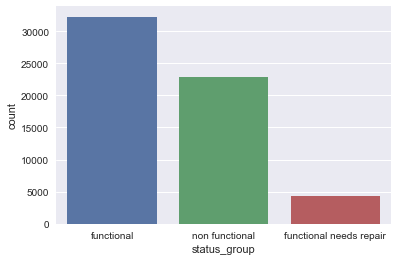

In [534]:
print('What do the waterpoint status labels look like? \n')
print(training_labels['status_group'].value_counts())
sns.countplot(x = 'status_group', data = training_labels)

This quick countplot of waterpoint status labels shows us that our labels are pretty unbalanced. 

In [616]:
print(training_labels)

          id             status_group
0      69572               functional
1       8776               functional
2      34310               functional
3      67743           non functional
4      19728               functional
5       9944               functional
6      19816           non functional
7      54551           non functional
8      53934           non functional
9      46144               functional
10     49056               functional
11     50409               functional
12     36957               functional
13     50495               functional
14     53752               functional
15     61848               functional
16     48451           non functional
17     58155           non functional
18     34169  functional needs repair
19     18274               functional
20     48375               functional
21      6091               functional
22     58500  functional needs repair
23     37862               functional
24     51058               functional
25     22308

## Some Data Visualization

Here are some maps made using Tableau showing the labels for waterpoints around Tanzania.

### Map of all of the waterpoints in Tanzania. Color reflects the status of the waterpump and size reflects the population recorded using that waterpump. 

While it's nice to see the entire county, there are so many waterpoints that it might be nice to inspect a smaller area.

<img src="Waterpoint_Tanzania.png">

### Let's look at only the region of Mtwara

Here in the region of Mtwara we can see a mix of functional, functional but need repair, and non functional waterpoints.

<img src="Waterpoint_Mtwara.png">

### Filter waterpoints to only show waterpoint types listed as "Other"

Now, we can see that the majority of waterpoints listed as "Other" are non functional even in places with large populations.

<img src="Waterpoint_Type_Other.png">

### Let's plot some of these features

In [535]:
everything = pd.merge(training_values, training_labels, how = 'inner', on = 'id')


 Pairplot of the numerical features:


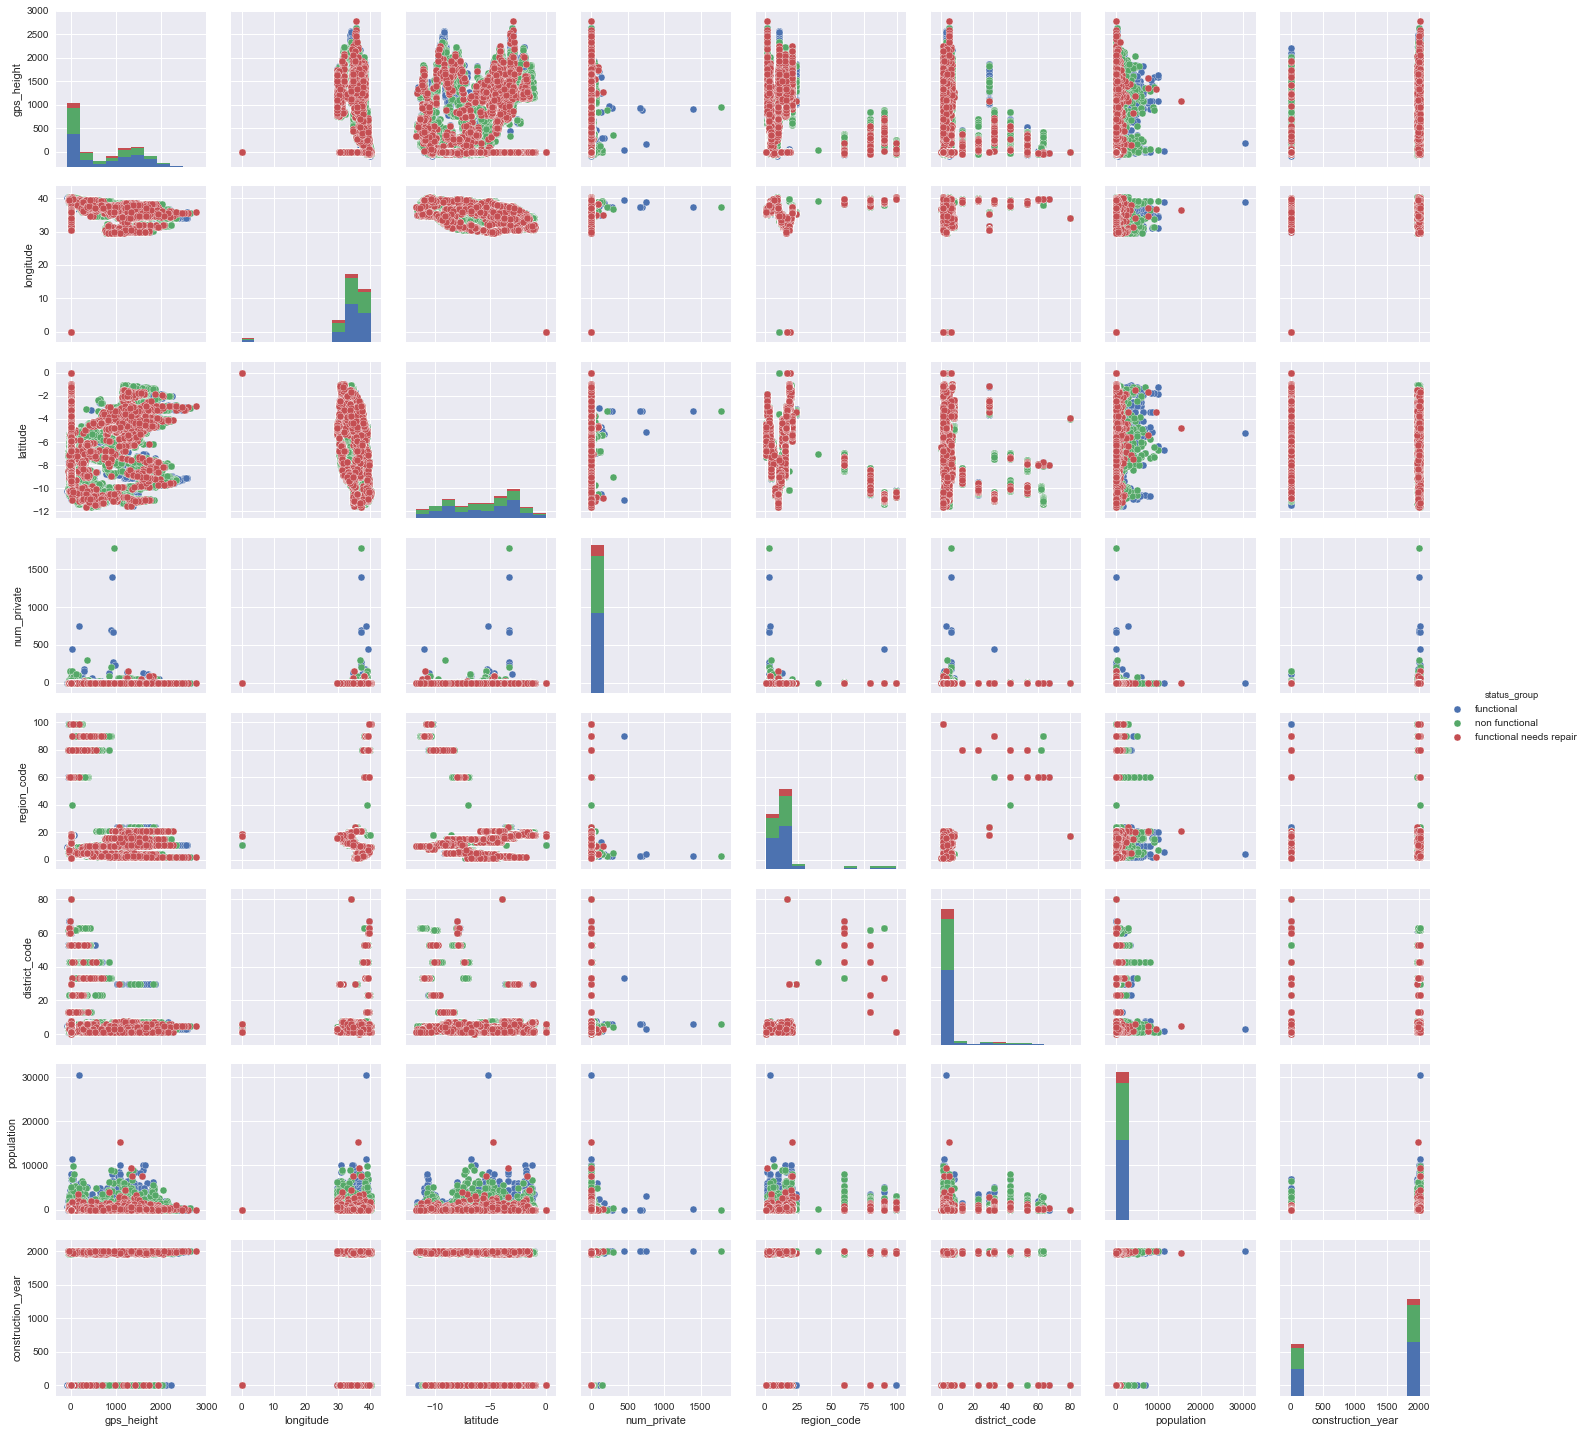

In [536]:
print('\n Pairplot of the numerical features:')
sns.pairplot(everything, vars = ['gps_height', 'longitude', 'latitude', 'num_private', 'region_code', 
                                 'district_code', 'population', 'construction_year'], hue = 'status_group')
plt.show()

## Feature Selection and Feature Engineering

In [238]:
# formatting the columns into categories and datetime

columns = ['district_code', 'extraction_type', 'quantity', 'source', 'public_meeting',
           'waterpoint_type', 'funder', 'installer', 'extraction_type_class', 'permit', 'management', 
           'payment_type', 'water_quality', 'basin', 'subvillage', 'region', 'lga', 'ward', 'recorded_by',
           'scheme_management', 'scheme_name', 'extraction_type_group', 'management_group', 'payment',
           'quality_group', 'source_type', 'source_class', 'waterpoint_type_group', 'wpt_name', 'quantity_group']

training_values[columns] = training_values[columns].apply(lambda x: x.astype('category'))
test_values[columns] = test_values[columns].apply(lambda x: x.astype('category'))

training_values['date_recorded'] = training_values['date_recorded'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
test_values['date_recorded'] = test_values['date_recorded'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))

training_values.funder.value_counts()

funder_list = ['Government Of Tanzania', 'Danida', 'Hesawa', 'Rwssp', 'World Bank', 'Kkkt', 'World Vision', 'Unicef']
everything = pd.merge(training_values, training_labels, how = 'inner', on = 'id')
everything['funder'] = everything['funder'].apply(lambda x: x if x in funder_list else 'Other')
training_values['funder'] = training_values['funder'].apply(lambda x: x if x in funder_list else 'Other')
test_values['funder'] = test_values['funder'].apply(lambda x: x if x in funder_list else 'Other')

everything.funder.value_counts()

sns.countplot(x = 'funder', data = everything, hue = 'status_group')
plt.show()

### longitude, latitude, and gps_height

There are 1812 timems that zero was entered for longitude. Everytime longitude was recorded as zero, latitude was recorded as -2.000000e-08, and gps_height was recorded as zero. 

To replace the zero values with something semi-accurate, I computed the mean longitude, mean latitude, and mean gps_height for each region and saved them to a dictionary. Then, when an instance of zero longitude was found, I replaced the longitude, latitude, and gps_height with the mean of the region that waterpoint existed.

In [239]:
# small region dataframe

region_df = training_values[['region_code', 'longitude', 'latitude', 'gps_height']].copy()
region_df = region_df.sort_values(['region_code'])
region_df[:5]

,region_code,longitude,latitude,gps_height
31023,1,36.040140,-4.729822,0
10601,1,36.479069,-6.174439,0
54054,1,36.489771,-7.104349,0
39734,1,35.830580,-4.381180,0
39723,1,35.993264,-7.026813,0


In [240]:
# calculates mean longitude, mean latitude, and mean gps_height for each region

def region_mean(df):
    old_region = None
    lats = []
    longs = []
    hts = []
    region_dict = {}
    
    for index, row in df.iterrows():
        this_region = int(row['region_code'])
        this_lat = float(row['latitude'])
        this_long = float(row['longitude'])
        this_ht = float(row['gps_height'])
        
        # if this is the first in a region
        if old_region and old_region != this_region:
            
            # printing out the previous region's mean_lat and mean_long
            mean_lat = float(np.mean(lats))
            mean_long = float(np.mean(longs))
            mean_ht = float(np.mean(hts))
            #print('%s mean lat: %f, mean long: %f' % (old_region, mean_lat, mean_long))
            region_dict[old_region] = {}
            region_dict[old_region]['mean_lat'] = mean_lat
            region_dict[old_region]['mean_long'] = mean_long
            region_dict[old_region]['mean_ht'] = mean_ht
            
            # reset mean_lat and mean_long
            lats = []
            longs = []
            hts = []
        
        # update region
        old_region = this_region
        
        # this region is the same as last region, append lats and longs
        lats.append(this_lat)
        longs.append(this_long)
        hts.append(this_ht)
        
    # print out very last region
    if old_region != None:
        mean_lat = float(np.mean(lats))
        mean_long = float(np.mean(longs))
        mean_ht = float(np.mean(hts))
        #print('%s mean lat: %f, mean long: %f' % (old_region, mean_lat, mean_long))
        region_dict[old_region] = {}
        region_dict[old_region]['mean_lat'] = mean_lat
        region_dict[old_region]['mean_long'] = mean_long
        region_dict[old_region]['mean_ht'] = mean_ht
        
    return region_dict

# make the dictionary

region_dict = region_mean(region_df)

In [241]:
# function to replace the long, lat, and gps_height in the instances longitude equals zero

def replace_zeros(df, dictionary):
    
    for index, row in df.iterrows():
        region = int(row['region_code'])
        
        if row['longitude'] == 0.0:
            df.loc[index, 'longitude'] = region_dict.get(region).get('mean_long')
            df.loc[index, 'latitude'] = region_dict.get(region).get('mean_lat')
            df.loc[index, 'gps_height'] = region_dict.get(region).get('mean_ht')
            
    return df

# calling the replace_zeros function for the training and test sets

training_values = replace_zeros(training_values, region_dict)
test_values = replace_zeros(test_values, region_dict)

### date_recorded

The rainy season is in March, April, and May. Maybe if the waterpoint information was collected during one of those months is affects the label of the waterpoint. I added a month column using the date_recorded feature to determine if recording data during the rainy season made an impact on waterpoint status classification

https://www.expertafrica.com/tanzania/info/tanzania-weather-and-climate

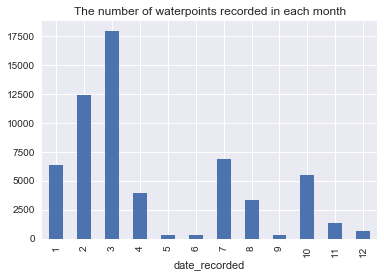

In [242]:
training_values['date_recorded'].groupby(training_values["date_recorded"].dt.month).count().plot(kind = "bar",
                                                    title = 'The number of waterpoints recorded in each month')

In [243]:
# populating the column 'rainy' with whether or not it was a rainy month when 
# the waterpoint status was recorded

def rainy_month(date):
    if date.month > 2 and date.month < 6:
        rainy = 1
    else: 
        rainy = 0
    return rainy
        
training_values['rainy'] = training_values.apply(
    lambda row: rainy_month(row['date_recorded']), axis = 1)
test_values['rainy'] = test_values.apply(
    lambda row: rainy_month(row['date_recorded']), axis = 1)

training_values.month = training_values['rainy'].astype('category')
test_values.month = test_values['rainy'].astype('category')

### years in service (recorded year - construction year)

There are 20709 instances of zero recorded as the construction year of the waterpoint in the training set.  

What can I do with all of the instances of zero? 

In [244]:
# we know that a zero for the construction_year is really a missing entry
# let's replace the zero values with the mean

training_values.construction_year = training_values['construction_year'].replace(0, np.NaN)
test_values.construction_year = test_values['construction_year'].replace(0, np.NaN)

con_year_mean = math.ceil(training_values['construction_year'].mean())
print('The construction_year mean is:', con_year_mean)

training_values.construction_year = training_values['construction_year'].fillna(con_year_mean)
test_values.construction_year = test_values['construction_year'].fillna(con_year_mean)

The construction_year mean is: 1997


In [245]:
training_values['years_service'] = 0
test_values['years_service'] = 0

def years_service(df):
    
    for index, row in df.iterrows():
        rec_date = df.loc[index, 'date_recorded']
        rec_year = rec_date.year
        con_year = df.loc[index, 'construction_year']
        df.loc[index, 'years_service'] = rec_year - con_year
    return df

years_service(training_values)
years_service(test_values)

training_values.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,rainy,years_service
0,69572,6000.0,2011-03-14,Roman,1390.0,Roman,34.938093,-9.856322,none,0,...,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,1,12.0
1,8776,0.0,2013-03-06,Grumeti,1399.0,GRUMETI,34.698766,-2.147466,Zahanati,0,...,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,1,3.0
2,34310,25.0,2013-02-25,Lottery Club,686.0,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,0,4.0
3,67743,0.0,2013-01-28,Unicef,263.0,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,0,27.0
4,19728,0.0,2011-07-13,Action In A,0.0,Artisan,31.130847,-1.825359,Shuleni,0,...,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,0,14.0


## LDA

Used Sebastian Raschka's Linear Discriminant Analysis article to investigate dimensionality reduction.

This is all written out long-hand instead of using scikit-learn's LinearDiscrimantAnalysis because this is new to me and I wanted to see it coded out.

In [246]:
df = training_values.copy()
df_test = test_values.copy()

# F for features
F = df[['amount_tsh', 'gps_height', 'longitude', 'latitude', 'num_private', 
                    'population', 'construction_year', 'years_service']].values
F_test = df_test[['amount_tsh', 'gps_height', 'longitude', 'latitude', 'num_private', 
                    'population', 'construction_year', 'years_service']].values

# t for target
t = training_labels['status_group'].values

enc = LabelEncoder()
label_encoder = enc.fit(t)
t = label_encoder.transform(t) + 1

label_dict = {1: 'Functional', 2: 'Non Functional', 3:'Functional Needs Repair'}

feature_dict = {i:label for i,label in zip(range(7), 
                ('amount_tsh', 'gps_height', 'longitude', 'latitude', 'num_private',
                'population', 'construction_year', 'years_service'))}

In [247]:
# Mean vectors of the three different status group classes

np.set_printoptions(precision=4)

mean_vectors = []
for cl in range(1,4):
    mean_vectors.append(np.mean(F[t == cl], axis=0))
    print('Mean Vector class %s: %s\n' %(cl, mean_vectors[cl-1]))

Mean Vector class 1: [  4.6180e+02   7.4247e+02   3.4936e+01  -5.7715e+00   5.3901e-01
   1.8755e+02   1.9990e+03   1.2917e+01]

Mean Vector class 2: [  2.6707e+02   6.3251e+02   3.3575e+01  -5.4015e+00   3.0762e-01
   1.7510e+02   1.9960e+03   1.6095e+01]

Mean Vector class 3: [  1.2348e+02   5.7726e+02   3.4999e+01  -5.8649e+00   4.1395e-01
   1.7002e+02   1.9941e+03   1.7847e+01]



In [248]:
# Scatter Matrices

S_W = np.zeros((8,8))
for cl,mv in zip(range(1,4), mean_vectors):
    class_sc_mat = np.zeros((8,8))                  # scatter matrix for every class
    for row in F[t == cl]:
        row, mv = row.reshape(8,1), mv.reshape(8,1) # make column vectors
        class_sc_mat += (row-mv).dot((row-mv).T)
    S_W += class_sc_mat                             # sum class scatter matrices
print('Within-Class Scatter Matrix:\n', S_W)

overall_mean = np.mean(F, axis=0)

S_B = np.zeros((8,8))
for i,mean_vec in enumerate(mean_vectors):  
    n = F[t == i+1,:].shape[0]
    mean_vec = mean_vec.reshape(8,1) # make column vector
    overall_mean = overall_mean.reshape(8,1) # make column vector
    S_B += n * (mean_vec - overall_mean).dot((mean_vec - overall_mean).T)

print('Between-Class Scatter Matrix:\n', S_B)

Within-Class Scatter Matrix:
 [[  5.3219e+11   8.6524e+09   1.1068e+07  -2.6557e+07   5.8087e+06
    1.2869e+09  -1.2587e+07   1.1980e+07]
 [  8.6524e+09   2.7976e+10   7.6275e+06  -9.7972e+05   3.2636e+06
    2.5521e+09  -1.5204e+07   2.7859e+07]
 [  1.1068e+07   7.6275e+06   5.4150e+05  -1.8136e+05   9.0979e+04
    7.5324e+06   2.5329e+04  -1.0169e+04]
 [ -2.6557e+07  -9.7972e+05  -1.8136e+05   4.7513e+05   1.6874e+04
   -1.0453e+06   5.0097e+04  -2.4791e+04]
 [  5.8087e+06   3.2636e+06   9.0979e+04   1.6874e+04   8.8932e+06
    1.2754e+06  -3.4205e+04   2.4757e+04]
 [  1.2869e+09   2.5521e+09   7.5324e+06  -1.0453e+06   1.2754e+06
    1.3200e+10   6.8623e+06  -3.3127e+06]
 [ -1.2587e+07  -1.5204e+07   2.5329e+04   5.0097e+04  -3.4205e+04
    6.8623e+06   5.6950e+06  -5.6850e+06]
 [  1.1980e+07   2.7859e+07  -1.0169e+04  -2.4791e+04   2.4757e+04
   -3.3127e+06  -5.6850e+06   5.7295e+06]]
Between-Class Scatter Matrix:
 [[  1.5418e+09   7.5617e+08   2.0358e+04   3.3347e+05   6.0476e+05

In [249]:
# Solving the eigenvalue problem

eig_vals, eig_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

for i in range(len(eig_vals)):
    eigvec_sc = eig_vecs[:,i].reshape(8,1)   
    print('\nEigenvector {}: \n{}'.format(i+1, eigvec_sc.real))
    print('Eigenvalue {:}: {:.2e}'.format(i+1, eig_vals[i].real))

    
# Checking the eigenvector-eigenvalue calculation

for i in range(len(eig_vals)):
    eigv = eig_vecs[:,i].reshape(8,1)
    np.testing.assert_array_almost_equal(np.linalg.inv(S_W).dot(S_B).dot(eigv),
                                         eig_vals[i] * eigv,
                                         decimal = 6, err_msg = '', verbose = True)
print('\nok')


Eigenvector 1: 
[[ -1.4502e-04]
 [ -2.0390e-03]
 [ -3.4568e-02]
 [ -7.5348e-02]
 [ -2.9037e-03]
 [ -3.3476e-05]
 [  5.7578e-01]
 [  8.1338e-01]]
Eigenvalue 1: 8.01e-02

Eigenvector 2: 
[[  2.3191e-05]
 [ -1.2343e-04]
 [ -4.5120e-01]
 [ -5.9751e-02]
 [  2.9252e-03]
 [  9.9886e-05]
 [  6.3704e-01]
 [  6.2212e-01]]
Eigenvalue 2: 1.74e-02

Eigenvector 3: 
[[-0.001 ]
 [-0.0069]
 [ 0.183 ]
 [ 0.3087]
 [ 0.0029]
 [ 0.0011]
 [ 0.7913]
 [ 0.495 ]]
Eigenvalue 3: -1.14e-16

Eigenvector 4: 
[[ -3.5406e-05]
 [ -1.5123e-03]
 [  4.3649e-02]
 [ -1.3581e-01]
 [ -4.6737e-03]
 [ -2.0804e-04]
 [  7.3046e-01]
 [  6.6788e-01]]
Eigenvalue 4: 6.83e-16

Eigenvector 5: 
[[ 0.0019]
 [-0.0014]
 [-0.2715]
 [-0.9332]
 [-0.0075]
 [-0.0016]
 [-0.1953]
 [-0.1314]]
Eigenvalue 5: -1.70e-17

Eigenvector 6: 
[[  2.4509e-04]
 [  1.9474e-04]
 [ -2.8663e-01]
 [ -9.5407e-01]
 [ -5.0452e-02]
 [ -3.2003e-03]
 [ -4.8431e-02]
 [ -5.1844e-02]]
Eigenvalue 6: -3.29e-18

Eigenvector 7: 
[[ 0.001 ]
 [-0.0018]
 [ 0.3311]
 [ 0.8363]
 [

In [250]:
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs = sorted(eig_pairs, key = lambda k: k[0], reverse = True)

# Visually confirm that the list is correctly sorted by decreasing eigenvalues

print('Eigenvalues in decreasing order:\n')
for i in eig_pairs:
    print(i[0])
    
print('\n\nVariance explained:\n')
eigv_sum = sum(eig_vals)
for i,j in enumerate(eig_pairs):
    print('eigenvalue {0:}: {1:.2%}'.format(i+1, (j[0]/eigv_sum).real))


Eigenvalues in decreasing order:

0.0800811261833
0.017447283102
6.83104068659e-16
1.13939572827e-16
1.69757113125e-17
3.28565744652e-18
7.28604879399e-19
1.57624778479e-19


Variance explained:

eigenvalue 1: 82.11%
eigenvalue 2: 17.89%
eigenvalue 3: 0.00%
eigenvalue 4: 0.00%
eigenvalue 5: 0.00%
eigenvalue 6: 0.00%
eigenvalue 7: 0.00%
eigenvalue 8: 0.00%


In [251]:
W = np.hstack((eig_pairs[0][1].reshape(8,1), eig_pairs[1][1].reshape(8,1)))
print('Matrix W:\n', W.real)


Matrix W:
 [[ -1.4502e-04   2.3191e-05]
 [ -2.0390e-03  -1.2343e-04]
 [ -3.4568e-02  -4.5120e-01]
 [ -7.5348e-02  -5.9751e-02]
 [ -2.9037e-03   2.9252e-03]
 [ -3.3476e-05   9.9886e-05]
 [  5.7578e-01   6.3704e-01]
 [  8.1338e-01   6.2212e-01]]


In [252]:
F_lda = F.dot(W)
F_test_lda = F_test.dot(W)

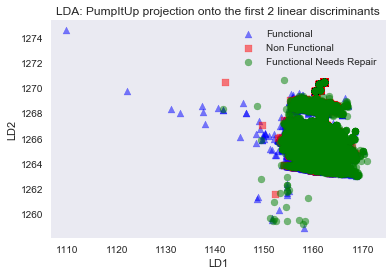

In [253]:
def plot_step_lda():

    ax = plt.subplot(111)
    for label,marker,color in zip(
        range(1,4),('^', 's', 'o'),('blue', 'red', 'green')):

        plt.scatter(x = F_lda[:,0].real[t == label],
                y = F_lda[:,1].real[t == label],
                marker = marker,
                color = color,
                alpha = 0.5,
                label = label_dict[label]
                )

    plt.xlabel('LD1')
    plt.ylabel('LD2')

    leg = plt.legend(loc = 'upper right', fancybox = True)
    leg.get_frame().set_alpha(0.5)
    plt.title('LDA: PumpItUp projection onto the first 2 linear discriminants')

    # hide axis ticks
    plt.tick_params(axis = 'both', which = 'both', bottom = 'off', top = 'off',  
            labelbottom = 'on', left = 'off', right = 'off', labelleft = 'on')

    # remove axis spines
    ax.spines['top'].set_visible(False)  
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)    

    plt.grid()
    plt.tight_layout
    plt.show()

plot_step_lda()

In [254]:
print(F_lda.shape)
print(training_values.shape)

print(F_test_lda.shape)
print(test_values.shape)

(59400, 2)
(59400, 42)
(14850, 2)
(14850, 42)


In [255]:
training_values['LD1'] = F_lda[:, 0]
training_values['LD2'] = F_lda[:, 1]
print(training_values.shape)

test_values['LD1'] = F_test_lda[:, 0]
test_values['LD2'] = F_test_lda[:, 1]
print(test_values.shape)

(59400, 44)
(14850, 44)


### population

Zero was entered 21381 times for population in the training set, I replaced the zeros in population with NaN

training_values.population = training_values['population'].replace(0, np.NaN)
test_values.population = test_values['population'].replace(0, np.NaN)

### gps_height

I chose to group the values of this feature by replacing the actual gps_height with a height range

In [256]:
training_values.gps_height = training_values.gps_height.apply(lambda x: '>500' if x > 500
                                                              else '0 to 500' if x > 0
                                                              else '0 or below')

test_values.gps_height = test_values.gps_height.apply(lambda x: '>500' if x > 500
                                                              else '0 to 500' if x > 0
                                                              else '0 or below')

training_values.gps_height = training_values.gps_height.astype('category')
test_values.gps_height = test_values.gps_height.astype('category')

### installer 

Replacing the 3655 times installer was entered as NaN with the mode.

In [257]:
#training_values.installer = training_values.installer.apply(
#    lambda x: 'other' if x.value_counts() < 100 else x)

threshold = 15
for col in training_values[['installer', 'funder', 'ward']]:
    value_counts = training_values[col].value_counts()
    to_replace = value_counts[value_counts <= threshold].index
    training_values[col].replace(to_replace, 'other', inplace = True)
    test_values[col].replace(to_replace, 'other', inplace = True)

## Encoding Categorical features and splitting the data into training and test sets

In [258]:
X = training_values.drop(['id', 'wpt_name', 'date_recorded', 'amount_tsh', 'longitude', 'latitude', 'num_private', 'population', 'construction_year',
                        'extraction_type_class', 'extraction_type_group', 'quality_group', 'source', 'recorded_by', 'years_service',
                        'quantity_group', 'region_code', 'subvillage', 'scheme_name'], axis = 1)

y = training_labels['status_group']

X_test_data = test_values.drop(['id', 'wpt_name', 'date_recorded', 'amount_tsh', 'longitude', 'latitude', 'num_private', 'population', 'construction_year',
                        'extraction_type_class', 'extraction_type_group', 'quality_group', 'source', 'recorded_by', 'years_service', 
                        'quantity_group', 'region_code', 'subvillage', 'scheme_name'], axis = 1)

In [259]:
X.columns

Index(['funder', 'gps_height', 'installer', 'basin', 'region', 'district_code',
       'lga', 'ward', 'public_meeting', 'scheme_management', 'permit',
       'extraction_type', 'management', 'management_group', 'payment',
       'payment_type', 'water_quality', 'quantity', 'source_type',
       'source_class', 'waterpoint_type', 'waterpoint_type_group', 'rainy',
       'LD1', 'LD2'],
      dtype='object')

In [260]:
columns = ['installer', 'funder', 'basin', 'region', 'payment', 'gps_height', 'management', 'rainy',
           'public_meeting', 'permit', 'extraction_type', 'scheme_management', 'ward', 'lga', 
           'management_group', 'payment_type', 'water_quality', 'quantity', 'source_type', 'source_class', 
           'waterpoint_type', 'waterpoint_type_group', 'district_code']

X = pd.get_dummies(X[columns], dummy_na = True)
X_test_data = pd.get_dummies(X_test_data[columns], dummy_na = True)

X_test_data = X_test_data.reindex(columns = X.columns, fill_value=0)

In [261]:
print(X.shape)
print(X_test_data.shape)

(59400, 2629)
(14850, 2629)


In [262]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 6)

## Random Forest Classifier

In [263]:
rf_classifier = RandomForestClassifier(n_estimators = 200, criterion = 'entropy',
                                       min_samples_split = 6,
                                       random_state = 6)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=6, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=1, oob_score=False, random_state=6,
            verbose=0, warm_start=False)

In [264]:
rf_y_pred = rf_classifier.predict(X_test)
rf_score = rf_classifier.score(X_test, y_test)
print('Random Forest Classifier Mean Accuracy:', rf_score)
cm = confusion_matrix(y_test, rf_y_pred, labels = ['functional', 'non functional', 'functional needs repair'])
print(cm)

Random Forest Classifier Mean Accuracy: 0.798372615039
[[8590  859  167]
 [1517 5253  103]
 [ 700  247  384]]


## Make a prediction on the test data

In [176]:
predictions = rf_classifier.predict(X_test_data)

In [177]:
test_ids = np.array(test_values['id'].astype(int))
solution = pd.DataFrame(predictions, test_ids, columns = ['status_group'])

In [178]:
print(solution.head())
print(solution.shape)

         status_group
50785  non functional
51630      functional
17168      functional
45559  non functional
49871      functional
(14850, 1)


In [1741]:
solution.to_csv('solution6.csv', index_label = ['id'])